# Shamir Secret Sharing

In this notebook we will study the properties of polynomials to perform secret sharing and defining the properties of sum and multiplication, the protocol we will learn is called Shamir secret sharing and was published by Adi Shamir in 1979, you can read the paper [here](http://users.cms.caltech.edu/~vidick/teaching/101_crypto/Shamir1979.pdf). At the same time will investigate the difference between Shamir secret sharing and additive secret sharing.

## Polynomials

We look at polynomials and their properties. First let's look at a simple polynomial say $$f(x)=3+x+2x^2-x^3$$

and plot it a graph. Also we plot a random sampling of the polynomial points.

<Figure size 432x288 with 0 Axes>

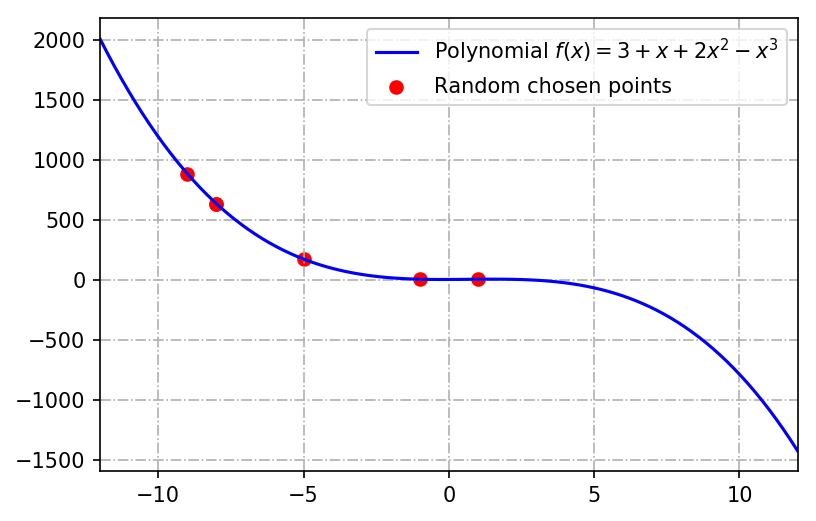

Random points are:
[(-9, 885), (-8, 635), (-8, 635), (1, 5), (-5, 173), (-1, 5)]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randrange, seed

seed(2)

# Defining the polynomial
def poly3(x):
    return 3+1*x+2*x**2-x**3

# Generate 5 random points
points = []
while len(points)<6:
    x = randrange(-10, 10)
    points.append((x, poly3(x)))

# Plotting
plt.clf()
x = np.linspace(-12,12,100)
fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x,poly3(x), 'b', label="Polynomial $f(x)=3+x+2x^2-x^3$")
plt.scatter([a[0] for a in points], [a[1] for a in points], c='r', label="Random chosen points")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{points}")

Can we reconstruct the exact full polynomial with few random sampled points? The answer is yes, we need as many as $t$ points, being $t$ larger than $n$ the degree of the polynomial. Imagine we want to fit a line, how many points do we need? just two, a parabola? we need three points and so on. This uniqueness of solution allows to define a sharing scheme over polinomials.

## Shamir

Think of the field (mathematically speaking) of all the polynomials whose coeficients are in the field $Z$ modulo p, for ideally a large prime. We can define a secret as the independent term of the polinomial, this is:
$$f(x)=s+a_1x+a_2x^2+...+a_nx^n$$

where $n$ is the degree and all the coefficients are randomly chosen values in $Z$ modulo p. Let me define a function to randomly saple a polinomial with a secret

In [2]:
from crypt import RandomPrime
from random import randrange

bits = 16
p = RandomPrime(bits, 40)

print(f"Chosen prime number p={p} of {bits} bits")

def RandomPolynomial(s, n, p):
    # s is the secret, n the degree of polynomial and p the prime number for the field
    coef = [s]
    while len(coef)<n+1:
        coef.append(randrange(1, p))
    return coef

secret = 10
degree = 5
coefficients = RandomPolynomial(secret, degree, p)

print(f"A random polynomial drawn from the coefficient field F_p:\n")
for i, coef in enumerate(coefficients):
    if i==0:
        print(f"secret = a{i} = {coef}")
    else:
        print(f"a{i} = {coef}")

Chosen prime number p=61981 of 16 bits
A random polynomial drawn from the coefficient field F_p:

secret = a0 = 10
a1 = 57456
a2 = 59503
a3 = 40393
a4 = 17573
a5 = 50659


Making the shares at this point is easy, we just have to draw as many random points as we want and send them to the parties. Let's make a function to evaluate the polynomial at certain points given their coefficients.

In [3]:
def PolyEvaluate(coef, x):
    # Horner's method to evaluate polynomial
    # coef is a list of the coefficients [a0, a1,..., an]
    n = len(coef)
    coef = coef[::-1]
    r = coef[0]   
    for i in range(1, n): 
        r = r*x + coef[i] 
    return r 


## Using machine learing to guess the polynomial

Before moving on with addition and multiplication in polynomials we will try to guess how much can we reconstruct of a polynomial having some points. To do that we will use ordinary least squares (basically a linear regression) to try to guess the coefficients. Since it is a convex problem we don't need to optimise any learning rate hyperparameter, instead this is just a matrix inversion operation (not detailed here).

In [4]:
bits = 2
p = RandomPrime(bits, 40)

# points to randomly sample, degree of poly and secret

degree = 3
secret = 10

coef = RandomPolynomial(secret, degree, p)
print(f"Generating a random polynomial of degree {degree} and secret {secret} over prime number {p}")
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

Generating a random polynomial of degree 3 and secret 10 over prime number 3
Coefficients of random polynomial:
a0=10
a1=2
a2=2
a3=2


I write a helper function to draw random points and generate the data for the fit. Recall that what we do is simply find a random variable $x$ and get $f(x)$ without adding any noise.

In [5]:
import statsmodels.api as sm
from crypt import isPrime

def _generate_data(n_points, degree, coef, rng = (-10, 10)):
    """
    Draw distinct points from a coefficient of certain degree and coefficients in a list
    """
    if not isPrime(p, 100):
        raise ValueError(f"{p} is not prime, please enter the prime number generating coefficients")
    x = []
    while len(x)<n_points:
        i = randrange(rng[0], rng[1])
        
        # avoid sharing the secret and repeat shares
        if i not in x and i!=0:
            x.append(i)
    x = np.array(x)

    s = []
    while len(s)<degree:
        s.append(x**(len(s)+1))

    X = np.column_stack(s)
    # Add the independent term
    X = sm.add_constant(X)
    y = np.array([PolyEvaluate(coef, point) for point in x])
    
    return X, y, x


### Number of drawn points smaller than polynomial degree

In [6]:
n_points = 2

X, y, x = _generate_data(n_points, degree, coef)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print(f"Coefficients of random polynomial: {coef}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 11 Feb 2020   Prob (F-statistic):                nan
Time:                        22:18:57   Log-Likelihood:                 58.792
No. Observations:                   2   AIC:                            -113.6
Df Residuals:                       0   BIC:                            -116.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0860        inf          0        n

/usr/local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1698: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


As yu can see the polynomial coefficients are by no means similar to the ones generated randomly, also the standard error calculated is numerically infinite. This intuitively means that we cannot recostruct the polynomial. In fact this is well known in the data science community, the model is too complex (high degree of polynomial) to fit the data (fewer points), this is called underfitting. Let's see a plot of the data and the generated one



<Figure size 432x288 with 0 Axes>

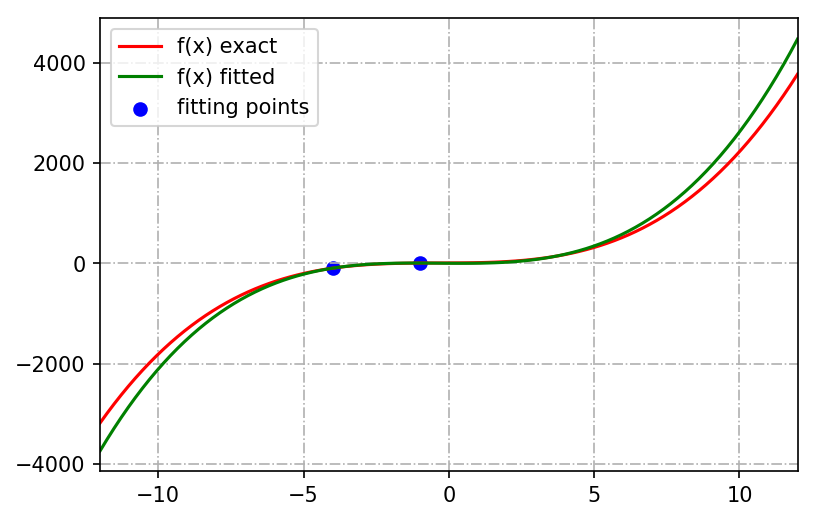

Random points are:
[-1 -4]
Coefficients of random polynomial:
a0=10
a1=2
a2=2
a3=2


In [7]:
fitted_coef = results.params

# Plotting
plt.clf()

fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
r = np.linspace(-12,12,100)
plt.scatter(x, [PolyEvaluate(coef, a) for a in x], c='b', label="fitting points")
plt.plot(r, [PolyEvaluate(coef, a) for a in r], 'r', label=f"f(x) exact")
plt.plot(r, [PolyEvaluate(fitted_coef, a) for a in r], 'g', label=f"f(x) fitted")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{x}")
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

It looks as if the two graphs are very similar, in fact they both pass through the points (x, y) selected. The fitted polynomial lacks information and this is why even though he can reconstruct much of the curve it has long tails where no information is provided.

### Number of drawn points larger than polynomial degree

In [8]:
n_points = 10

X, y, x = _generate_data(n_points, degree, coef)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.981e+31
Date:                Tue, 11 Feb 2020   Prob (F-statistic):           2.42e-95
Time:                        22:18:57   Log-Likelihood:                 280.89
No. Observations:                  10   AIC:                            -553.8
Df Residuals:                       6   BIC:                            -552.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0000   1.26e-13   7.94e+13      0.0

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


Here you can see that now the coefficients are matched perfectly (if you compare with the original data) and the standard error of them is very small. A large $t$ indicates that we have strong evidence that these values are correct (using t-statistics). See that we recovered the secret!. Let's again plot the two lines, the origial polynomial and the fitted one.

<Figure size 432x288 with 0 Axes>

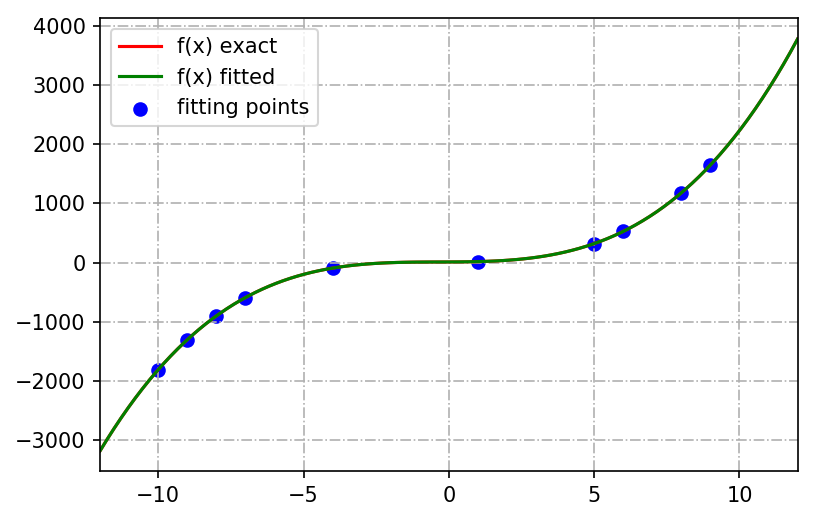

Random points are:
[  5   6   1   9  -8 -10  -4  -7  -9   8]
Coefficients of random polynomial:
a0=10
a1=2
a2=2
a3=2


In [9]:
fitted_coef = results.params

# Plotting
plt.clf()

fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
r = np.linspace(-12,12,100)
plt.scatter(x, [PolyEvaluate(coef, a) for a in x], c='b', label="fitting points")
plt.plot(r, [PolyEvaluate(coef, a) for a in r], 'r', label=f"f(x) exact")
plt.plot(r, [PolyEvaluate(fitted_coef, a) for a in r], 'g', label=f"f(x) fitted")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{x}")
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

This time both lines lie one on top of the other. We have "perfectly" reconstructed the original polynomial by sampling $t$>$n$ points.


## Lagrange polynomial reconstruction

The reconstruction shown above has a strong assumption, this is, we consider that the coefficients of the polynomial are real numbers. This means that if we find that the secret is 10 with a very small standard deviation we are quite sure that the value is close to 10 but it could also be 10.00000001. We are lucky because we work on the field of polynomials with coefficients in $\mathbb{Z}_p$ and so the coefficinets are constrained by the natural numbers. this is:

$$f(x)=\sum_{i=0}^{n}a_ix^i=a_0+a_1x+a_2x^2+\cdots+a_nx^n$$

where $a_i$ coefficients belong to the integer modulo $p$ field ($a_i \in \mathbb{Z}_p$). 

This kind of polynomials on $\mathbb{Z}_p$ can be reconstructed exactly using [Lagrange interpolation](https://en.wikipedia.org/wiki/Lagrange_polynomial). 

Lagrange interpolation theorem: Given $t$ distinct points ($x_i$, $y_i$) where $y_i=f(x)$ and $f(x)$ is a poloynomial of degree less than $t$ then $f(x)$ is determined by

$$f(x)=\sum_{i=1}^ty_i\prod_{j=1, j!=n}^{t}\frac{x-x_j}{x_i-x_j}$$

We are interested in recovering the secret, thus on the value $f(0)$

$$s=x_0=f(0)=\sum_{i=1}^ty_i\prod_{j=1, j!=n}^{t}\frac{x_j}{x_j-x_i}$$

Let's code a function that calculates the value of the polynomial at any given point given the shares (points).

In [10]:
def LagrangeInterpolation(x, points):
    """
    Given t shares calculate the interpolation of the polynomial of degree
    t-1 at point x.
    Input: 
        x: the point where we want to calculate f(x)
        points: a set of values (xi, yi) randomly sampled from the polynomial
    """
    #Check all points are distinct
    distinct_xi = set([x for x,y in points])
    if len(points)!=len(distinct_xi):
        raise ValueError("Points at which we evaluate the polynomial must be all different")
    
    summands = []
    for i, (xi, yi) in enumerate(points):
        val = 1
        for j, (xj, yj) in enumerate(points):
            if i!=j:
                #val=val*(x-xj)*InverseFermat((xi-xj), p)%p
                val*=(x-xj)/(xi-xj)
                
        val*=yi
        #val*=yi%p
        summands.append(val)
    
    # cast it to integer (has to be since x and y are all integers and f is polynomial)
    # same time to avoid numerical errors we round the number
    return int(round(sum(summands)))

**Definition**: A $(t, n)$ threshold secret sharing scheme is a method for $n$ parties to carry shares si of
a message s such that any $t$ of the them to reconstruct the message, but so that no $t − 1$
of them can easy do so. The threshold scheme is perfect if knowledge of $t − 1$ or fewer
shares provides no information regarding $s$.

This is perfect in this scheme, we can reconstruct the polynomial 

In [11]:
bits = 32
p = RandomPrime(bits, 40)

# points to randomly sample, degree of poly and secret

degree = 5
secret = randrange(1, p)

coef = RandomPolynomial(secret, degree, p)
print(f"Generating a random polynomial of degree {degree} and secret {secret} over prime number {p}")
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

Generating a random polynomial of degree 5 and secret 1358523605 over prime number 2284377449
Coefficients of random polynomial:
a0=1358523605
a1=438297594
a2=103954651
a3=1923380228
a4=547764930
a5=2226021866


In [12]:
t = degree+1
_, y, x = _generate_data(t, degree, coef)
points = list(zip(list(x), list(y)))

In [13]:
points

[(-7, -36753901104790),
 (8, 76182218337125),
 (1, 6597942874),
 (2, 98034917813),
 (4, 2547545535853),
 (-6, -17012621704507)]

In [14]:
print(f"We want to find the secret of a polynomial of degree {degree}, we need t={t} shares to reconstruct it.")
print("Random shares generated:\n")
for xi, yi in points:
    print(f"f({xi})={yi}")

We want to find the secret of a polynomial of degree 5, we need t=6 shares to reconstruct it.
Random shares generated:

f(-7)=-36753901104790
f(8)=76182218337125
f(1)=6597942874
f(2)=98034917813
f(4)=2547545535853
f(-6)=-17012621704507


In [15]:
print("Evaluating at different points using evaluation from coefficinets and interpolation:")
for i in range(-5, 5):
    f = PolyEvaluate(coef, i)%p
    lag = LagrangeInterpolation(i, points)%p
    print(f"x={i}, f({i})={f}, f({i})_lagrange={lag}")
    
    if f!=lag:
        print("\nLagrange interpolation or polynomial evaluation is wrong, values do not coincide\n\n")
    

Evaluating at different points using evaluation from coefficinets and interpolation:
x=-5, f(-5)=510470410, f(-5)_lagrange=510470410
x=-4, f(-4)=487378859, f(-4)_lagrange=487378859
x=-3, f(-3)=744190178, f(-3)_lagrange=744190178
x=-2, f(-2)=711077631, f(-2)_lagrange=711077631
x=-1, f(-1)=1991298396, f(-1)_lagrange=1991298396
x=0, f(0)=1358523605, f(0)_lagrange=1358523605
x=1, f(1)=2029187976, f(1)_lagrange=2029187976
x=2, f(2)=2091064955, f(2)_lagrange=2091064955
x=3, f(3)=1206861450, f(3)_lagrange=1206861450
x=4, f(4)=464680218, f(4)_lagrange=464680218


Now we can recover the secret with the points, we just need to evaluate $f(0)$:

In [16]:
recovered_secret = LagrangeInterpolation(0, points)
if recovered_secret!=secret:
    print("Something went wrong, we couldn't recover the secret")
print(f"Our successfully recovered secret is {recovered_secret} :)")

Our successfully recovered secret is 1358523605 :)


We've recovered the secret well. This shows you how the protocol should work. Recall that we've not worked on modulo $p$ in the $x$ and $y$ of the polynomial, just on the coefficients. We have to restrict ourselves to modulo operation in all the following. I've implemented this in a library.

## Packing up the concepts in a package

First let's import the libraries, there's documentation on how to use them (e.g. type help(ShamirRandomPolynomial) on a python cell)

In [27]:
from smpc import ShamirRandomPolynomial, DrawPolynomialPoints, LagrangeInterpolation, PolyEvaluateModulo

In [28]:
help(ShamirRandomPolynomial)

Help on function ShamirRandomPolynomial in module smpc:

ShamirRandomPolynomial(s: int, n: int, p: int) -> List[int]
    Calculates the coeficients living on a field Zp for a polynomial of degree n
    Input:
        s: secret, independent term of the polynomial
        n: degree of the polynomial, we need t=n+1 to reconstruct
        p: prime number to generate the coeffients
    Output:
        A list of integers with the coefficients [a0, a1, a2,...,an]



In [29]:
help(DrawPolynomialPoints)

Help on function DrawPolynomialPoints in module smpc:

DrawPolynomialPoints(shares: int, coef: List[int], p: int, rng: Tuple[int, int] = (0, 20)) -> List[Tuple[int, int]]
    Draw distinct points from a coefficient of certain degree and coefficients in a list
    Inputs:
        shares: number of points to be drawn randomly
        coef: the list of coefficients of the polynomial. Degree is len(coef)-1
        p: the prime over which the ring is generated
        rng: range of x to be selected randomly.
    
    returns:
        A list of tuples [(x0, f(x0)), (x1, f(x1)),...,(x_npoints-1, f(x_npoints-1))]
        those are random points (not repeated) sampled from the polynomial with x in the range
        of the parameter rng



In [30]:
help(LagrangeInterpolation)

Help on function LagrangeInterpolation in module smpc:

LagrangeInterpolation(x: int, shares: List[Tuple[int, int]], p: int) -> int
    Given t shares calculate the interpolation of the polynomial of degree
    t-1 at point x.
    Input: 
        x: the point where we want to calculate f(x)
        shares: a set of values (xi, yi) randomly sampled from the polynomial
    Returns:
        the value f(x) for the polynomial with degree len(points)-1 (fully determined)



In [31]:
help(PolyEvaluateModulo)

Help on function PolyEvaluateModulo in module smpc:

PolyEvaluateModulo(coef: List[int], x: int, p: int) -> int
    Horner's method to evaluate polynomial
    coef is a list of the coefficients [a0, a1,..., an], note this is 
    modulo p evaluation. Not real valued polynomials
    
    Input:
        coef: list of coefficients of the polynomial
        x: input where we want to evaluate the polynomial (x<p)
        p: the prime number over which the ring of polynomials is defined
    Returns:
        f(x), the evaluation of the polynomial at x in modulo



Let's do a quick example on a large field

In [32]:
bits = 128
p = RandomPrime(bits, 100)

degree = 6
secret = 100

coef = ShamirRandomPolynomial(s=secret, n=degree, p=p)

print(f"Ring of polynomials with degree {degree} and prime {p}")
print(f"Selected random polynomial on p:\n")
for i, elem in enumerate(coef):
    print(f"a{i}={elem}")

Ring of polynomials with degree 6 and prime 175655851248680744869904703766183870717
Selected random polynomial on p:

a0=100
a1=113851930371867485544625102656756105048
a2=10141197018044105193164737849751881373
a3=158545424799935227647801770518121767908
a4=104631387257329405116721465237834141374
a5=140066884913669788985247814576266487374
a6=1229994457414541542285757074086677053


In [33]:
points = DrawPolynomialPoints(degree+1, coef, p, rng=(0, p))
print("Random points drawn from polynomial generated above:\n")
for point in points:
    interpolated = LagrangeInterpolation(point[0], points, p)
    if interpolated != point[1]:
        print("Some Error occurred, the interpolation may not be correct")
    else:
        print(f"x={point[0]}, f(x)={point[1]}, correct interpolation!")

Random points drawn from polynomial generated above:

x=84561389162957652659455759714784187577, f(x)=8056652587191741129422363411025571791, correct interpolation!
x=123184641561815150729616521778917791375, f(x)=78091069888343313712302686453025823649, correct interpolation!
x=153741536758019819225702873948983607088, f(x)=142924980706757034670636572977941227978, correct interpolation!
x=125026789880122758133760660702649199926, f(x)=121420500211264067307247090245504913721, correct interpolation!
x=52009555762399937778856777552512344930, f(x)=117394597905525517271871458238165064658, correct interpolation!
x=145772551540978069800324309169127311281, f(x)=27923623623071288075426339759034440324, correct interpolation!
x=88423076818937913209541547593355823976, f(x)=130399279117575783548274769931915473182, correct interpolation!


A useful function is RevealSecret that gives us the intercept (or secret) of the polynomial given the shares

In [34]:
from smpc import RevealSecret

print(f"Reveling secret: {RevealSecret(points, p)}")

Reveling secret: 100


We've seen that this can be extended to large polynomial rings and that the interpolation works (in modulo sense). Now is time to define operations on polynomials.

## Sum on Shamir polynomials

All this construction is useful to sum two secrets in a privacy preserving way. Say Alice and Bob both generate two random polynomials of degree $t$ (we need N=t+1 to reconstruct) with their secret independent terms as $s_A$ and $s_B$, respectively. Can we use other parties to compute $s^A+s^B$?. The answer obviously is affirmative because the sum of two polynomials of the same degree results in a polynomial whose coefficients are the sum of the previous two. This is,

$$f^A(x)= s^A+a^A_1x+a^A_2x^ 2+\cdots a^A_nx^n$$
$$f^B(x)= s^B+a^B_1x+a^B_2x^ 2+\cdots a^B_nx^n$$
$$f^A(x)+f^B(x)= (s^A+s^B)+(a^A_1+a^B_1)x+(a^A_2+a^B_2)x^2+\cdots (a^A_n+a^B_n)x^n$$

Therefore the reconstruction of the secret sum is:
$$s= s^A+s^B$$
as we would expect.

To do this protocol first Alice and Bob have to agree on three things, first the prime number $p$ they will use for their randomly generated polynomials, then the degree of the polynomials and finally the evaluation points

In [54]:
bits = 128
p = RandomPrime(bits, 100)

# we need at least t+1 parties to reconstruct
t = 6

# agreed evaluation points for the polynomials, make sure to not
# include x=0. If we send this to any party it will reveal our secret
eval_points = [i for i in range(1, t+2)]

# Each party has a secret that want to sum
sa = randrange(1, 5000)
sb = randrange(1, 5000)

poly_Alice = ShamirRandomPolynomial(sa, t, p)
poly_Bob = ShamirRandomPolynomial(sb, t, p)

shares_Alice = [(i, PolyEvaluateModulo(poly_Alice, i, p)) for i in eval_points]
shares_Bob = [(i, PolyEvaluateModulo(poly_Bob, i, p)) for i in eval_points]

In [55]:
print(f"Alice's secret sa: {sa}")
print(f"Bob's secret sb: {sb}")
print()

print("Polynomial Generated Secretly by Alice:")
for i, c in enumerate(poly_Alice):
    print(f"a{i}={c}")

print()
print("Polynomial Generated Secretly by Bob:")
for i, c in enumerate(poly_Bob):
    print(f"a{i}={c}")
print()

print("Alice's Shares")
for x, y in shares_Alice:
    print(f"x={x}, f(x)={y}")

print()
print("Bobs's Shares")
for x, y in shares_Bob:
    print(f"x={x}, f(x)={y}")

Alice's secret sa: 492
Bob's secret sb: 4524

Polynomial Generated Secretly by Alice:
a0=492
a1=317914098622596523327930541847941098134
a2=72240483986267476336229551816692524735
a3=247910972593822174103323078367810813001
a4=167962819843076209291145405604633374612
a5=135271041321439347731882746061600883716
a6=283174210671953858562879758525438715439

Polynomial Generated Secretly by Bob:
a0=4524
a1=60162330752065044567139671257456936097
a2=15261003609455352268143341483095628335
a3=205271964509212785239669930389409810102
a4=322246826715426764336448316975069263334
a5=112097166261755779025007746855793137558
a6=299793490503858273611190449706073860591

Alice's Shares
x=1, f(x)=250426914271332833469602498195827555402
x=2, f(x)=124633404043580100261636751700936358334
x=3, f(x)=162834918254194324713869300232408543291
x=4, f(x)=246872703288398225033118291911290170869
x=5, f(x)=210457551623112180981438703853390081615
x=6, f(x)=109717790624155383201393916477847657704
x=7, f(x)=154051511496720664180

Now they both send their shares to the different parties, at least $t+1$ with every party having the same point of evaluation.

In [56]:
for i, ((xa, ya), (xb, yb)) in enumerate(zip(shares_Alice, shares_Bob)):
    assert xa==xb
    print(f"Party {i} gets shares evaluated at {xa}\n\tfrom Alice {ya}\n\tfrom Bob {yb}\n")

Party 0 gets shares evaluated at 1
	from Alice 250426914271332833469602498195827555402
	from Bob 40786069583951243163810872638608785814

Party 1 gets shares evaluated at 2
	from Alice 124633404043580100261636751700936358334
	from Bob 207302711461639520948901521546331637179

Party 2 gets shares evaluated at 3
	from Alice 162834918254194324713869300232408543291
	from Bob 147924870529456755593084756237874870876

Party 3 gets shares evaluated at 4
	from Alice 246872703288398225033118291911290170869
	from Bob 192059346265611732716773005925907470653

Party 4 gets shares evaluated at 5
	from Alice 210457551623112180981438703853390081615
	from Bob 197508086194567986591013101052259322846

Party 5 gets shares evaluated at 6
	from Alice 109717790624155383201393916477847657704
	from Bob 283550070797706642990419218311294317965

Party 6 gets shares evaluated at 7
	from Alice 154051511496720664180413641533469492935
	from Bob 202919413977471700018375375737825473679



Now each party performs the sum modulo p

In [57]:
shared_sum = []
for i, ((xa, ya), (xb, yb)) in enumerate(zip(shares_Alice, shares_Bob)):
    assert xa==xb
    shared_sum.append((xa, (ya+yb)%p))

With the sum of shares we can reconstruct the secret

In [61]:
s_reconstructed = RevealSecret(shared_sum, p)
assert s_reconstructed==(sa+sb)%p

print(f"The original sum of secrets is {(sa+sb)%p}")
print(f"The reconstructed secret from the shared sums is {s_reconstructed}")
print("Computation of the sum can be outsourced!")

The original sum of secrets is 5016
The reconstructed secret from the shared sums is 5016
Computation of the sum can be outsourced!
